In [ ]:
import sys
sys.path.insert(0, "..")

import os
print("Current working directory:", os.getcwd())

Current working directory: /work3/s185927/thesis


In [2]:
import os,torch

# Ensure cache is on scratch
os.environ["XDG_CACHE_HOME"] = "/work3/s185927/.cache"
os.environ["TORCH_HOME"] = "/work3/s185927/.cache/torch"
torch.hub.set_dir("/work3/s185927/.cache/torch/hub")

os.chdir("vjepa2")

# Remove any corrupted/partial checkpoints (both home and scratch, if present)
# for pat in [
#     os.path.expanduser("~/.cache/torch/hub/checkpoints/vjepa2-ac-vitg.pt*"),
#      "/work3/s185927/.cache/torch/hub/checkpoints/vjepa2-ac-vitg.pt*",
#  ]:
#      for f in glob.glob(pat):
#          print("Removing:", f)
#          try: os.remove(f)
#          except FileNotFoundError: pass

# print("hub dir:", torch.hub.get_dir())

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from notebooks.utils.mpc_utils import (
    compute_new_pose,
    poses_to_diff
)

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Initialize VJEPA 2-AC model
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")

# Move model to device
encoder = encoder.to(device).eval()
predictor = predictor.to(device).eval()

# Initialize transform
crop_size = 256
tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)

Using device: cuda


Using cache found in /work3/s185927/.cache/torch/hub/facebookresearch_vjepa2_main
/work3/s185927/thesis/miniconda/envs/vjepa2-312/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
# Load robot trajectory

play_in_reverse = False  # Use this FLAG to try loading the trajectory backwards, and see how the energy landscape changes

trajectory = np.load("notebooks/franka_example_traj.npz")
np_clips = trajectory["observations"]
np_states = trajectory["states"]
if play_in_reverse:
    np_clips = trajectory["observations"][:, ::-1].copy()
    np_states = trajectory["states"][:, ::-1].copy()
np_actions = np.expand_dims(poses_to_diff(np_states[0, 0], np_states[0, 1]), axis=(0, 1))

# Convert trajectory to torch tensors
clips = transform(np_clips[0]).unsqueeze(0).to(device)  
states = torch.tensor(np_states, device=device)
actions = torch.tensor(np_actions, device=device)
print(f"clips: {clips.shape}; states: {states.shape}; actions: {actions.shape}")

clips: torch.Size([1, 3, 2, 256, 256]); states: torch.Size([1, 2, 7]); actions: torch.Size([1, 1, 7])


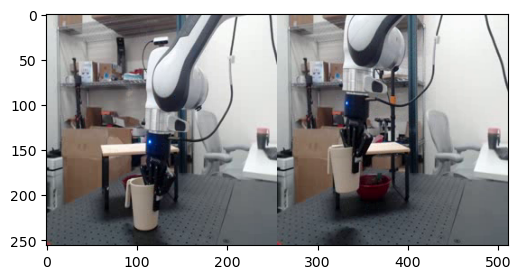

In [6]:
# Visualize loaded video frames from traj

T = len(np_clips[0])
plt.figure(figsize=(20, 3))
_ = plt.imshow(np.transpose(np_clips[0], (1, 0, 2, 3)).reshape(256, 256 * T, 3))

In [7]:
def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h


def forward_actions(z, nsamples, grid_size=0.075, normalize_reps=True, action_repeat=1):

    def make_action_grid(grid_size=grid_size):
        action_samples = []
        for da in np.linspace(-grid_size, grid_size, nsamples):
            for db in np.linspace(-grid_size, grid_size, nsamples):
                for dc in np.linspace(-grid_size, grid_size, nsamples):
                    action_samples += [torch.tensor([da, db, dc, 0, 0, 0, 0], device=z.device, dtype=z.dtype)]
        return torch.stack(action_samples, dim=0).unsqueeze(1)

    # Sample grid of actions
    action_samples = make_action_grid()
    print(f"Sampled grid of actions; num actions = {len(action_samples)}")

    def step_predictor(_z, _a, _s):
        _z = predictor(_z, _a, _s)[:, -tokens_per_frame:]
        if normalize_reps:
            _z = F.layer_norm(_z, (_z.size(-1),))
        _s = compute_new_pose(_s[:, -1:], _a[:, -1:])
        return _z, _s

    # Context frame rep and context pose
    z_hat = z[:, :tokens_per_frame].repeat(int(nsamples**3), 1, 1)  # [S, N, D]
    s_hat = states[:, :1].repeat((int(nsamples**3), 1, 1))  # [S, 1, 7]
    a_hat = action_samples  # [S, 1, 7]

    for _ in range(action_repeat):
        _z, _s = step_predictor(z_hat, a_hat, s_hat)
        z_hat = torch.cat([z_hat, _z], dim=1)
        s_hat = torch.cat([s_hat, _s], dim=1)
        a_hat = torch.cat([a_hat, action_samples], dim=1)

    return z_hat, s_hat, a_hat

def loss_fn(z, h):
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    loss = torch.abs(z - h)  # [B, N, D]
    loss = torch.mean(loss, dim=[1, 2])
    return loss.tolist()

In [8]:
# Compute energy for cartesian action grid of size (nsample x nsamples x nsamples)
nsamples = 5
grid_size = 0.075
with torch.no_grad():
    h = forward_target(clips)
    z_hat, s_hat, a_hat = forward_actions(h, nsamples=nsamples, grid_size=grid_size)
    loss = loss_fn(z_hat, h)  # jepa prediction loss

/work3/s185927/thesis/miniconda/envs/vjepa2-312/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Sampled grid of actions; num actions = 125


Ground truth action (x,y,z) = (0.09,0.03,0.08)


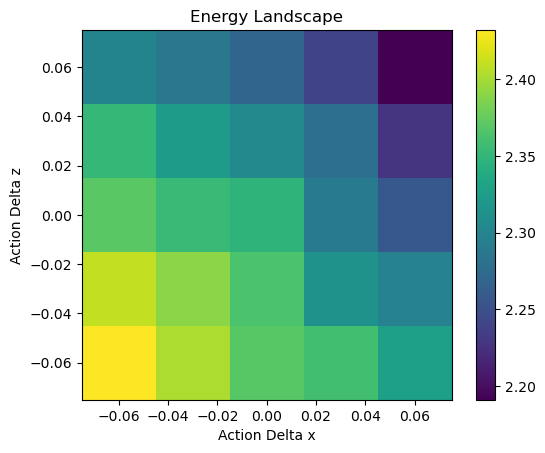

In [9]:
# Plot the energy

plot_data = []
for b, v in enumerate(loss):
    plot_data.append((
        a_hat[b, :-1, 0].sum().detach().cpu().item(),
        a_hat[b, :-1, 1].sum().detach().cpu().item(),
        a_hat[b, :-1, 2].sum().detach().cpu().item(),
        float(v),
    ))

delta_x = np.asarray([d[0] for d in plot_data], dtype=np.float32)
delta_z = np.asarray([d[2] for d in plot_data], dtype=np.float32)
energy  = np.asarray([d[3] for d in plot_data], dtype=np.float32)

gt_x = float(actions[0, 0, 0].detach().cpu().item() if torch.is_tensor(actions) else actions[0,0,0])
gt_y = float(actions[0, 0, 1].detach().cpu().item() if torch.is_tensor(actions) else actions[0,0,1])
gt_z = float(actions[0, 0, 2].detach().cpu().item() if torch.is_tensor(actions) else actions[0,0,2])

heatmap, xedges, yedges = np.histogram2d(delta_x, delta_z, weights=energy, bins=nsamples)

plt.xlabel("Action Delta x")
plt.ylabel("Action Delta z")
plt.title("Energy Landscape")
print(f"Ground truth action (x,y,z) = ({gt_x:.2f},{gt_y:.2f},{gt_z:.2f})")
_ = plt.imshow(heatmap.T, origin="lower",
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap="viridis")
_ = plt.colorbar()

In [10]:
# Compute the optimal action using MPC
from notebooks.utils.world_model_wrapper import WorldModel

world_model = WorldModel(
    encoder=encoder,
    predictor=predictor,
    tokens_per_frame=tokens_per_frame,
    transform=transform,
    # Doing very few CEM iterations with very few samples just to run efficiently on CPU...
    # ... increase cem_steps and samples for more accurate optimization of energy landscape
    mpc_args={
        "rollout": 1,
        "samples": 500,
        "topk": 10,
        "cem_steps": 2,
        "momentum_mean": 0.15,
        "momentum_mean_gripper": 0.15,
        "momentum_std": 0.75,
        "momentum_std_gripper": 0.15,
        "maxnorm": 0.075,
        "verbose": True
    },
    normalize_reps=True,
    device=str(device)
)

with torch.no_grad():
    h = forward_target(clips)
    z_n, z_goal = h[:, :tokens_per_frame], h[:, -tokens_per_frame:]
    s_n = states[:, :1]
    print(f"Starting planning using Cross-Entropy Method...")
    actions = world_model.infer_next_action(z_n, s_n, z_goal).cpu().numpy()

print(f"Actions returned by planning with CEM (x,y,z) = ({actions[0, 0]:.2f},{actions[0, 1]:.2f} {actions[0, 2]:.2f})")
print(f"Actions (pitch, yaw, roll, open) = ({actions[0, 3]:.2f},{actions[0, 4]:.2f} {actions[0, 5]:.2f} {actions[0, 6]:.2f})")

Starting planning using Cross-Entropy Method...
[INFO    ][2025-09-18 14:11:18][notebooks.utils.mpc_utils][cem                      ] new mean: tensor([0.0608, 0.0589, 0.0595, 0.1670], device='cuda:0') tensor([0.0583, 0.0588, 0.0582, 0.6584], device='cuda:0')
[INFO    ][2025-09-18 14:11:23][notebooks.utils.mpc_utils][cem                      ] new mean: tensor([0.0729, 0.0726, 0.0727, 0.6625], device='cuda:0') tensor([0.0437, 0.0441, 0.0437, 0.0988], device='cuda:0')
Actions returned by planning with CEM (x,y,z) = (0.07,0.07 0.07)
Actions (pitch, yaw, roll, open) = (0.00,0.00 0.00 0.66)


### Robot arm implementation


First define the world model used for planning


In [11]:
world_model = WorldModel(
    encoder=encoder,
    predictor=predictor,
    tokens_per_frame=tokens_per_frame,
    transform=transform,
    # Doing very few CEM iterations with very few samples just to run efficiently on CPU...
    # ... increase cem_steps and samples for more accurate optimization of energy landscape
    mpc_args={
        "rollout": 2,
        "samples": 100,
        "topk": 10,
        "cem_steps": 5,
        "momentum_mean": 0.15,
        "momentum_mean_gripper": 0.15,
        "momentum_std": 0.75,
        "momentum_std_gripper": 0.15,
        "maxnorm": 0.075,
        "verbose": True
    },
    normalize_reps=True,
    device=str(device)
)

In [35]:
# ===== Imports =====
import threading
import numpy as np
import ipywidgets as W
from IPython.display import display
from IPython.core.debugger import set_trace as ipdb

import pybullet as p
import pybullet_data as pd
import cv2
import time, math


# ===== Config =====
SIM_FPS       = 300
TARGET_FPS    = 60            # 24–30 if you need lighter updates
WIDTH, HEIGHT = 720, 480      # lower => faster
USE_EGL       = True          # True if EGL is available
AUTO_START_SIM = True  

# ===== Fresh sim =====
try:
    p.disconnect()
except Exception:
    pass

if USE_EGL:
    p.connect(p.DIRECT, options="--egl")
else:
    p.connect(p.DIRECT)

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.setGravity(0, 0, -9.81)
p.setTimeStep(1.0 / SIM_FPS)

# World
p.loadURDF("plane.urdf", useFixedBase=True)               
table_id = p.loadURDF("table/table.urdf", [0, 0, 0], useFixedBase=True)


# Robot
panda = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0.625], useFixedBase=True)
EE_LINK, FINGER_L, FINGER_R = 11, 9, 10

# IK config (use 7-DOF arm limits, not all joints)
NUM_JOINTS = p.getNumJoints(panda)
ARM_JOINTS = list(range(7))
IK_LL   = [-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973]
IK_UL   = [ 2.8973,  1.7628,  2.8973, -0.0698,  2.8973,  3.7525,  2.8973]
IK_JR   = [u - l for l, u in zip(IK_LL, IK_UL)]
IK_DAMP = [0.1] * 7

table_aabb_min, table_aabb_max = p.getAABB(table_id)
TABLE_TOP_Z = float(table_aabb_max[2])
Z_SAFETY = 0.03  # 3 cm above the table
Z_MIN, Z_MAX = TABLE_TOP_Z + Z_SAFETY, 1.8

GRIPPER_ACTION_IS_DELTA = True

# Cube
CUBE_SCALE = 1.3
cube_xyz = [0.4, 0.00, 0.625 + 0.12]
cube = p.loadURDF("cube_small.urdf", cube_xyz, globalScaling=CUBE_SCALE, useFixedBase=False)

# Renderer
renderer = p.ER_BULLET_HARDWARE_OPENGL if USE_EGL else p.ER_TINY_RENDERER

# ===== Widgets =====
# Camera
cam_yaw   = W.FloatSlider(description="Yaw",   min=-180, max=180, step=0.2, value=0)
cam_pitch = W.FloatSlider(description="Pitch", min=-89,  max=0,   step=0.2, value=0)
cam_dist  = W.FloatSlider(description="Dist",  min=0.4,  max=3.0, step=0.05, value=1.5)
cam_tx    = W.FloatSlider(description="TargetX", min=0.3, max=0.8, step=0.01, value=0.25)
cam_ty    = W.FloatSlider(description="TargetY", min=-0.3, max=0.3, step=0.01, value=0.00)
cam_tz    = W.FloatSlider(description="TargetZ", min=0.05, max=1.0, step=0.01, value=1.00)

# 7D EE deltas relative to ORIGIN (m / deg)
dx = W.FloatText(description="Δx (m)",     value=0.00, step=0.005)
dy = W.FloatText(description="Δy (m)",     value=0.00, step=0.005)
dz = W.FloatText(description="Δz (m)",     value=0.00, step=0.005)
droll  = W.FloatText(description="Δroll°",  value=0.0, step=1.0)
dpitch = W.FloatText(description="Δpitch°", value=0.0, step=1.0)
dyaw   = W.FloatText(description="Δyaw°",   value=0.0, step=1.0)
grip_target = W.FloatSlider(description="Grip (m)", min=0.0, max=0.08, step=0.001, value=0.08)

# 7D EE deltas relative to CURRENT (m / deg)
rel_dx = W.FloatText(description="Δx (m)",     value=0.00, step=0.005)
rel_dy = W.FloatText(description="Δy (m)",     value=0.00, step=0.005)
rel_dz = W.FloatText(description="Δz (m)",     value=0.00, step=0.005)
rel_droll  = W.FloatText(description="Δroll°",  value=0.0, step=1.0)
rel_dpitch = W.FloatText(description="Δpitch°", value=0.0, step=1.0)
rel_dyaw   = W.FloatText(description="Δyaw°",   value=0.0, step=1.0)
rel_dgrip  = W.FloatText(description="Δgrip (m)", value=0.0, step=0.001)
rel_go_btn = W.Button(description="Execute Relative Move", button_style="success", icon="play")

# Buttons
set_goal_btn = W.Button(description="Set Goal Pose", button_style="primary")
reset_btn    = W.Button(description="↺ Reset animation", button_style="info")
snap_btn     = W.Button(description="Set Base = Current")
clear_btn    = W.Button(description="Clear Δ", button_style="warning")
respawn_btn  = W.Button(description="Respawn Cube", icon='refresh')
remove_btn   = W.Button(description="Remove Cube", icon='trash')
start_planning_btn = W.Button(description="Start Action Planning", button_style="primary")

# --- Log area ---
log_out = W.Output(layout=W.Layout(border='1px solid #444', width='100%', max_height='140px', overflow='auto'))

def log(msg):
    with log_out:
        print(msg)

# Goal pose variables
goal_rgb = None
goal_pos = None
goal_rpy = None
goal_grip = None

# Base pose variables
base_pos = None
base_rpy = None
base_grip = None


# Images
img = W.Image(format='jpeg');      
snap_img = W.Image(format='jpeg')

# Make images fill their column
img.layout = W.Layout(border='1px solid #444', width='100%')
snap_img.layout = W.Layout(border='1px solid #444', width='100%')

live_col = W.VBox([W.HTML("<b>Live</b>"), img],      layout=W.Layout(width='50%'))
snap_col = W.VBox([W.HTML("<b>Goal Snapshot</b>"), snap_img], layout=W.Layout(width='50%'))

two_up = W.HBox([live_col, snap_col], layout=W.Layout(width='100%', gap='12px', align_items='flex-start'))

# UI field for deltas to goal
goal_delta = W.HTML(value="<b>Δ to Goal:</b> —")
goal_distance = W.HTML(value="<b>Distance to Goal:</b> —")
current_pose = W.HTML(value="<b>Current EE pos:</b> —")

# Replace the separate Live/Snapshot lines in your ui with this:
ui = W.VBox([
    two_up,
    W.HTML("<b>Camera position settings</b>"),
    W.HBox([cam_yaw, cam_pitch, cam_dist]),
    W.HBox([cam_tx, cam_ty, cam_tz]),
    W.HTML("<b>Change end-effector state relative to base of robot arm</b>"),
    W.HBox([dx, dy, dz]),
    W.HBox([droll, dpitch, dyaw]),
    grip_target,
    W.HTML("<b>Relative EE Move</b>"),
    W.HBox([rel_dx, rel_dy, rel_dz]),
    W.HBox([rel_droll, rel_dpitch, rel_dyaw]),
    W.HBox([rel_dgrip, rel_go_btn]),
    current_pose,
    W.HBox([set_goal_btn, reset_btn, snap_btn, clear_btn, respawn_btn, remove_btn, start_planning_btn]),
    goal_delta, goal_distance,
    W.HTML("<b>Log</b>"),
    log_out,
])

display(ui)

# ===== Arm init =====
q_home = np.deg2rad([0, 0, 0, 0, 0, 0, 0]).astype(float)
for j in range(7):
    p.resetJointState(panda, j, float(q_home[j]))
    p.setJointMotorControl2(panda, j, p.POSITION_CONTROL, targetPosition=float(q_home[j]), force=800)

def _get_arm_q():
    return np.array([p.getJointState(panda, j)[0] for j in range(7)], dtype=float)

last_q = _get_arm_q()

# ===== Helpers =====
def _current_ee_pose():
    st = p.getLinkState(panda, EE_LINK, computeForwardKinematics=True)
    # Use the same frame IK solves for: linkWorldPosition/orientation (st[0], st[1])
    pos = np.array(st[0], dtype=float)
    rpy = np.array(p.getEulerFromQuaternion(st[1]), dtype=float)
    qL = p.getJointState(panda, FINGER_L)[0]
    qR = p.getJointState(panda, FINGER_R)[0]
    gripper_width = float(np.clip(qL + qR, 0.0, 0.08))
    return pos, rpy, gripper_width

def _wrap_deg(a):
    return (a + 180.0) % 360.0 - 180.0

def _execute_relative_move(_=None):
    # 1) Add relative deltas to the absolute (base-relative) sliders
    dx.value    = float(dx.value    + rel_dx.value)
    dy.value    = float(dy.value    + rel_dy.value)
    dz.value    = float(dz.value    + rel_dz.value)

    droll.value  = _wrap_deg(float(droll.value  + rel_droll.value))
    dpitch.value = _wrap_deg(float(dpitch.value + rel_dpitch.value))
    dyaw.value   = _wrap_deg(float(dyaw.value   + rel_dyaw.value))

    # Gripper (clamped to hardware limits)
    grip_target.value = float(np.clip(grip_target.value + rel_dgrip.value, 0.0, 0.08))

    # 2) Clear relative fields
    for w in (rel_dx, rel_dy, rel_dz, rel_droll, rel_dpitch, rel_dyaw, rel_dgrip):
        w.value = 0.0

    # 3) Ensure the player is running (it will smoothly servo to the new target)
    if not player.get("run", False):
        _run_animation(None)

    # 4) Refresh UI
    _refresh_img()
    _update_goal_delta()
    _update_euclidean_distance_to_goal()
    _update_current_pose()

def _servo_to_pose(tgt_pos, tgt_rpy, duration=0.20, pos_tol=1e-4, ori_tol_deg=0.2):
    """Iteratively re-solve IK and step until the EE is at target (smooth and precise)."""
    steps = max(1, int(duration * SIM_FPS))
    tgt_pos = np.asarray(tgt_pos, dtype=float)
    tgt_rpy = np.asarray(tgt_rpy, dtype=float)

    for s in range(steps):
        _set_arm_target(tgt_pos.tolist(), tuple(tgt_rpy))
        p.stepSimulation()
        if s % 3 == 0:
            pos_now, rpy_now, _ = _current_ee_pose()
            pos_err = float(np.linalg.norm(tgt_pos - pos_now))
            ori_err = float(np.max(np.abs(np.rad2deg(_wrap_to_pi(tgt_rpy - rpy_now)))))
            if pos_err < pos_tol and ori_err < ori_tol_deg:
                break

def _grab_frame_bytes(return_rgb=False):
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[float(cam_tx.value), float(cam_ty.value), float(cam_tz.value)],
        distance=float(cam_dist.value),
        yaw=float(cam_yaw.value),
        pitch=float(cam_pitch.value),
        roll=0.0,
        upAxisIndex=2
    )
    proj = p.computeProjectionMatrixFOV(fov=60.0, aspect=float(WIDTH/HEIGHT), nearVal=0.01, farVal=10.0)
    w, h, rgba, _, _ = p.getCameraImage(
        int(WIDTH), int(HEIGHT), view, proj, renderer=renderer, flags=p.ER_NO_SEGMENTATION_MASK
    )[:5]
    rgba = np.reshape(rgba, (h, w, 4))
    bgr = cv2.cvtColor(rgba[..., :3], cv2.COLOR_RGB2BGR)
    ok, buf = cv2.imencode(".jpg", bgr, [cv2.IMWRITE_JPEG_QUALITY, 70])

    if return_rgb:
        return buf.tobytes() if ok else None, rgba[:,:,:3]
    
    return buf.tobytes() if ok else None

def _refresh_img(*_):
    frame = _grab_frame_bytes()
    if frame is not None:
        img.value = frame

def _set_gripper(width, force=220):
    half = float(np.clip(width * 0.5, 0.0, 0.04))
    p.setJointMotorControl2(panda, FINGER_L, p.POSITION_CONTROL, targetPosition=half, force=force)
    p.setJointMotorControl2(panda, FINGER_R, p.POSITION_CONTROL, targetPosition=half, force=force)

def _set_arm_target(xyz, rpy):
    """Solve IK and set PD targets for arm joints."""
    global last_q
    q7 = _ik_solve(xyz, rpy)
    last_q = q7.copy()
    for j, qj in zip(ARM_JOINTS, q7):
        p.setJointMotorControl2(
            panda, j, p.POSITION_CONTROL,
            targetPosition=float(qj),
            force=600,              # was 900
            positionGain=0.5,       # was 0.8
            velocityGain=0.9,       # was 1.2
            maxVelocity=1.2         # new: cap joint speed (rad/s)
        )

def _set_goal(_=None):
    frame, rgb = _grab_frame_bytes(return_rgb=True)
    # Get current EE state (this becomes the goal)
    pos, rpy, gripper_width = _current_ee_pose()
    log(f"Goal EE pos = ({pos[0]:.3f}, {pos[1]:.3f}, {pos[2]:.3f}), rpy = ({np.rad2deg(rpy[0]):.1f}, {np.rad2deg(rpy[1]):.1f}, {np.rad2deg(rpy[2]):.1f}), grip = {gripper_width:.3f} m")
    global goal_rgb, goal_pos, goal_rpy, goal_grip
    goal_rgb = rgb
    goal_pos, goal_rpy, goal_grip = pos.copy(), rpy.copy(), float(gripper_width)
    _update_goal_delta()
    _update_euclidean_distance_to_goal()
    if frame is None:
        return None
    return frame

def _wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def _update_goal_delta():
    if goal_pos is None:
        goal_delta.value = "<b>Δ to Goal:</b> —"
        return
    pos, rpy, grip = _current_ee_pose()
    dpos = goal_pos - pos
    drpy = _wrap_to_pi(goal_rpy - rpy)
    dgrip = goal_grip - grip
    goal_delta.value = (
        f"<b>Δ to Goal</b> "
        f"dx={dpos[0]:+0.3f} dy={dpos[1]:+0.3f} dz={dpos[2]:+0.3f} m | "
        f"droll={np.rad2deg(drpy[0]):+0.1f}° dpitch={np.rad2deg(drpy[1]):+0.1f}° dyaw={np.rad2deg(drpy[2]):+0.1f}° | "
        f"dgrip={dgrip:+0.3f} m"
    )

def _update_euclidean_distance_to_goal():
    if goal_pos is None:
        goal_distance.value = "<b>Distance to Goal:</b> —"
        return
    pos, _, _ = _current_ee_pose()
    dpos = goal_pos - pos
    distance = np.linalg.norm(dpos)
    goal_distance.value = f"<b>Distance to Goal:</b> {distance:.3f} m"

def _update_current_pose():
    pos, rpy, grip = _current_ee_pose()
    current_pose.value = (
        f"<b>Current EE pos:</b> "
        f"x={pos[0]:0.3f} y={pos[1]:0.3f} z={pos[2]:0.3f} m | "
        f"roll={np.rad2deg(rpy[0]):0.1f}° pitch={np.rad2deg(rpy[1]):0.1f}° yaw={np.rad2deg(rpy[2]):0.1f}° | "
        f"grip={grip:0.3f} m"
    )

def _ik_solve(xyz, rpy):
    """Return 7-DOF arm joint solution with correct damping size."""
    global last_q
    orn = p.getQuaternionFromEuler(rpy)
    rest_7 = [float(qv) for qv in last_q.tolist()]
    try:
        q = p.calculateInverseKinematics2(
            bodyUniqueId=panda,
            endEffectorLinkIndex=EE_LINK,
            targetPosition=xyz,
            targetOrientation=orn,
            lowerLimits=IK_LL, upperLimits=IK_UL, jointRanges=IK_JR,
            restPoses=rest_7,
            jointDamping=[0.1] * len(ARM_JOINTS),
            jointIndices=ARM_JOINTS,
            maxNumIterations=256,
            residualThreshold=1e-5,
            solver=p.IK_DLS,
        )
        q7 = np.array(q, dtype=float)
    except TypeError:
        # Fallback for older PyBullet builds
        q = p.calculateInverseKinematics(
            panda, EE_LINK, xyz, orn,
            lowerLimits=IK_LL, upperLimits=IK_UL, jointRanges=IK_JR,
            restPoses=rest_7,
            maxNumIterations=256,
            residualThreshold=1e-5,
        )
        q7 = np.array([q[j] for j in ARM_JOINTS], dtype=float)
    return q7

# ===== Cube ops =====
def _respawn_cube(_=None):
    global cube, cube_xyz
    try:
        p.removeBody(cube)
    except Exception:
        pass

    cube_xyz = [0.3, 0, TABLE_TOP_Z + 0.02]  # 2 cm above table
    cube = p.loadURDF("cube_small.urdf", cube_xyz, globalScaling=CUBE_SCALE, useFixedBase=False)
    _refresh_img()

def _remove_cube(_=None):
    global cube
    try:
        p.removeBody(cube)
    except Exception:
        pass
    cube = None
    _refresh_img()

# ===== Live 7D player =====
player = {"run": False, "thread": None}
base_pos, base_rpy, base_grip = _current_ee_pose()


def _snap_base(_=None):
    global base_pos, base_rpy, base_grip
    base_pos, base_rpy, base_grip = _current_ee_pose()

    _update_goal_delta()
    _update_euclidean_distance_to_goal()
    _update_current_pose()

def _clear_delta(_=None):
    dx.value = dy.value = dz.value = 0.0
    droll.value = dpitch.value = dyaw.value = 0.0

def _player_loop():
    i = 0
    # Let sim settle initially
    for _ in range(SIM_FPS * 2): # Run for 2s
        p.stepSimulation()

    steps_per_frame = max(1, int(SIM_FPS / TARGET_FPS))
    while player["run"]:
        frame_start_time = time.time()

        dpos = np.array([dx.value, dy.value, dz.value], dtype=float)
        drpy = np.deg2rad([droll.value, dpitch.value, dyaw.value]).astype(float)

        tgt_pos = base_pos + dpos
        tgt_pos[2] = float(np.clip(tgt_pos[2], Z_MIN, Z_MAX))
        tgt_rpy = base_rpy + drpy

        # Precise per-frame servo instead of a few loose steps
        _servo_to_pose(tgt_pos, tgt_rpy, duration= 1.0 / TARGET_FPS)

        _set_gripper(float(np.clip(grip_target.value, 0.0, 0.08)))
        
        # Refresh image and UI state only once per frame
        if i % steps_per_frame == 0:
            _refresh_img()
            _update_goal_delta()
            _update_euclidean_distance_to_goal()
            _update_current_pose()

        # Try to match TARGET_FPS
        elapsed = time.time() - frame_start_time
        sleep_time = (1.0 / TARGET_FPS) - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

        i += 1

def _run_animation(_=None):
    if player["run"]:
        return
    _snap_base()

    global last_q
    last_q = _get_arm_q()  # reset IK seed to current

    player["run"] = True
    t = threading.Thread(target=_player_loop, daemon=True)
    player["thread"] = t
    t.start()

def _reset(_=None):
    global base_pos, base_rpy, reset_base_q, reset_base_grip, last_q, base_grip
    was_running = player.get("run", False)
    player["run"] = False
    t = player.get("thread")
    if t and t.is_alive():
        t.join(timeout=0.5)

    if reset_base_q is not None:
        for j, qj in enumerate(reset_base_q):
            p.resetJointState(panda, j, float(qj))
        half = float(np.clip(reset_base_grip * 0.5, 0.0, 0.04))
        p.resetJointState(panda, FINGER_L, half)
        p.resetJointState(panda, FINGER_R, half)
        for _ in range(2):
            p.stepSimulation()
        last_q = reset_base_q.copy()
        pos, rpy, _ = _current_ee_pose()
        base_pos = pos.copy()
        base_rpy = rpy.copy()
        base_grip = float(reset_base_grip)
    else:
        tgt_pos = (reset_base_pos if reset_base_pos is not None else base_pos).tolist()
        tgt_rpy = tuple(reset_base_rpy if reset_base_rpy is not None else base_rpy)
        _set_arm_target(tgt_pos, tgt_rpy)
        for _ in range(60):
            p.stepSimulation()
        base_pos = np.array(tgt_pos, dtype=float)
        base_rpy = np.array(tgt_rpy, dtype=float)
        # Restore gripper too if we have a saved width
        if 'reset_base_grip' in globals() and reset_base_grip is not None:
            _set_gripper(float(reset_base_grip))
            base_grip = float(reset_base_grip)

    # Keep slider consistent so player loop does not overwrite restored width
    if 'reset_base_grip' in globals() and reset_base_grip is not None:
        grip_target.value = float(reset_base_grip)

    _clear_delta()
    _refresh_img()
    _update_goal_delta()
    _update_euclidean_distance_to_goal()
    _update_current_pose()
    _run_animation(None)

def _goal_snapshot(_=None):
    frame = _set_goal()
    if frame is not None:
        snap_img.value = frame

def _free_cuda_cache():
    import gc, torch
    for name in [
        'z_hat','s_hat','a_hat','loss',
        'plot_data','delta_x','delta_z','energy',
        'heatmap','xedges','yedges'
    ]:
        if name in globals():
            try: del globals()[name]
            except: pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def _start_planning(_=None):
    # Check if goal_rgb is defined
    if goal_rgb is None:
        log("Error: No snapshot taken yet. Please take a snapshot first.")
        return

    # Free any big tensors from earlier cells (energy landscape, plots, etc.)
    _free_cuda_cache()

    with torch.no_grad():
        # Grab current frame RGB
        _, rgb = _grab_frame_bytes(return_rgb=True)

        # Batch the current + goal frames
        combined_rgb = np.stack([rgb, goal_rgb], axis=0) # [2, H, W, 3]
        clips = transform(combined_rgb).unsqueeze(0).to(device)  # [1, 3, T, H, W]
        
        # Get current state
        pos, rpy, gripper_width = _current_ee_pose()
        log("Starting action planning from current pose: " + ", ".join([f"{v:.3f}" for v in pos]) + " m, " + ", ".join([f"{np.rad2deg(v):.1f}" for v in rpy]) + " deg, " + f"grip {gripper_width:.3f} m")
        # Concat and to tensor
        current_state = np.concatenate([pos, rpy, [gripper_width]], axis=0)
        states = torch.tensor(current_state, device=device).unsqueeze(0).unsqueeze(0)  # [1, 1, 7]
        
        # Forward pass through world model to get optimal action
        h = forward_target(clips)
        # clone slices so we can free h
        z_n   = h[:, :tokens_per_frame].contiguous().clone()
        z_goal = h[:, -tokens_per_frame:].contiguous().clone()
        _free_cuda_cache()
        s_n = states[:, :1].to(dtype=z_n.dtype)
        
        # Time the planning
        start_time = time.time()
        actions = world_model.infer_next_action(z_n, s_n, z_goal).cpu().numpy()
        end_time = time.time()
        log(f"Planning time: {end_time - start_time:.3f} seconds")

        log(f"Planned action (x,y,z) = ({actions[0, 0]:.3f},{actions[0, 1]:.3f} {actions[0, 2]:.3f})")
        log(f"Planned action (pitch,yaw,roll,open) = ({actions[0, 3]:.2f},{actions[0, 4]:.2f} {actions[0, 5]:.2f} {actions[0, 6]:.2f})")


# ---- Room helpers ----
_room_bodies = []

def _add_wall(center, size_xyz, rgba=(0.94,0.95,0.97,1.0), texture=None):
    hx, hy, hz = [s*0.5 for s in size_xyz]
    col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[hx, hy, hz])
    vis = p.createVisualShape(p.GEOM_BOX, halfExtents=[hx, hy, hz], rgbaColor=rgba)
    bid = p.createMultiBody(baseMass=0.0, baseCollisionShapeIndex=col,
                            baseVisualShapeIndex=vis, basePosition=center)
    if texture:
        try:
            tex_id = p.loadTexture(texture)
            # Set tint to white so texture shows as-is
            p.changeVisualShape(bid, -1, textureUniqueId=tex_id, rgbaColor=[1,1,1,1])
        except Exception as e:
            log(f"Texture load failed: {e}")
    _room_bodies.append(bid)
    return bid

def _clear_room():
    global _room_bodies
    for b in _room_bodies:
        try: p.removeBody(b)
        except: pass
    _room_bodies = []

def _camera_world_pos():
    tx, ty, tz = float(cam_tx.value), float(cam_ty.value), float(cam_tz.value)
    dist, yaw, pitch = float(cam_dist.value), math.radians(float(cam_yaw.value)), math.radians(float(cam_pitch.value))
    cx = tx + dist * math.cos(pitch) * math.sin(yaw)
    cy = ty + dist * math.cos(pitch) * math.cos(yaw)
    cz = tz + dist * math.sin(pitch)
    return np.array([cx, cy, cz], dtype=float)

def _build_room_auto(margin=2.0, height=5, thickness=0.04,
                     color=(0.94,0.95,0.97,1.0), texture=None):
    """Enclose workspace + camera. Optional texture on all walls."""
    _clear_room()
    # workspace around table @ (0,0)
    ws_xmin, ws_xmax = -0.2, 1.2
    ws_ymin, ws_ymax = -0.7, 0.7
    cam = _camera_world_pos()
    xmin = min(ws_xmin, cam[0]) - margin; xmax = max(ws_xmax, cam[0]) + margin
    ymin = min(ws_ymin, cam[1]) - margin; ymax = max(ws_ymax, cam[1]) + margin
    z0 = 0.0; zc = z0 + height/2.0

    # back/front
    _add_wall(center=((xmin+xmax)/2, ymin - thickness/2, zc), size_xyz=(xmax-xmin, thickness, height),
              rgba=color, texture=texture)
    _add_wall(center=((xmin+xmax)/2, ymax + thickness/2, zc), size_xyz=(xmax-xmin, thickness, height),
              rgba=color, texture=texture)
    # left/right
    _add_wall(center=(xmin - thickness/2, (ymin+ymax)/2, zc), size_xyz=(thickness, ymax-ymin, height),
              rgba=color, texture=texture)
    _add_wall(center=(xmax + thickness/2, (ymin+ymax)/2, zc), size_xyz=(thickness, ymax-ymin, height),
              rgba=color, texture=texture)
    # optional ceiling:
    # _add_wall(center=((xmin+xmax)/2, (ymin+ymax)/2, z0 + height + thickness/2),
    #           size_xyz=(xmax-xmin + 2*thickness, ymax-ymin + 2*thickness, thickness),
    #           rgba=color, texture=texture)


_build_room_auto(margin=2.0)  # big enough that camera is always inside


# ===== Wire UI =====
respawn_btn.on_click(_respawn_cube)
remove_btn.on_click(_remove_cube)
set_goal_btn.on_click(_goal_snapshot)
reset_btn.on_click(_reset)
snap_btn.on_click(_snap_base)
clear_btn.on_click(_clear_delta)
start_planning_btn.on_click(_start_planning)
rel_go_btn.on_click(_execute_relative_move)


# Auto-refresh on camera changes
for w in (cam_yaw, cam_pitch, cam_dist, cam_tx, cam_ty, cam_tz):
    w.observe(_refresh_img, 'value')

# ===== First frame =====
_snap_base()
_set_gripper(grip_target.value)
_refresh_img()
_update_goal_delta()
_update_euclidean_distance_to_goal()
_update_current_pose()

if AUTO_START_SIM:
    _run_animation(None)


argv[0]=--egl
